In [381]:
!python3 --version

Python 3.8.10


In [382]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

Descrição dos dados:<br>
- id (int) - Identificador único da carta no banco de dados do jogo<br>
- name (str) - Nome da carta<br>
- mana (int) - Custo de mana para colocar a carta na mesa<br>
- attack (int) - Dano que a carta causa ao oponente<br>
- health (int) - Resistência ao dano ou durabilidade da carta<br>
- type (str) - ['spell','creature','weapon','god power']<br>
- god (str) - ['death','neutral','deception','nature','light','war','magic']<br>
- strategy (str) - Estágio do jogo ['early','late']

In [383]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,name,mana,attack,health,type,god,strategy
0,1118,Firewine,5,0,0,spell,nature,early
1,1036,Leyhoard Hatchling,10,2,1,creature,magic,late
2,244,Aetherfuel Alchemist,6,4,4,creature,neutral,late
3,215,Millenium Matryoshka,4,2,2,creature,neutral,late
4,87013,Poison Peddler,4,1,3,creature,neutral,late


In [384]:
df.describe()

,id,mana,attack,health
count,788.000000,788.000000,788.000000,788.000000
mean,18138.823604,3.572335,2.140863,2.583756
std,36607.267608,2.190100,2.215047,2.455053
min,1.000000,0.000000,0.000000,0.000000
25%,256.500000,2.000000,0.000000,0.000000
50%,902.000000,3.000000,2.000000,2.000000
75%,1196.250000,5.000000,3.000000,4.000000
max,100920.000000,16.000000,13.000000,17.000000


In [385]:
# Verificando a existência de valores nulos

df.isnull().sum()

id          0
name        0
mana        0
attack      0
health      0
type        0
god         0
strategy    0
dtype: int64

## Entendendo a distribuição dos dados

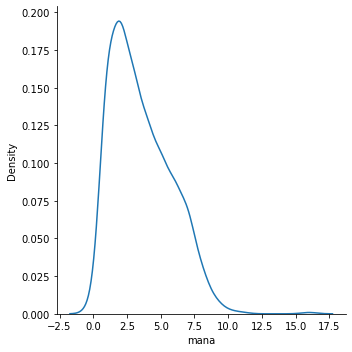

In [386]:
sns.displot(data=df, x="mana", kind="kde")

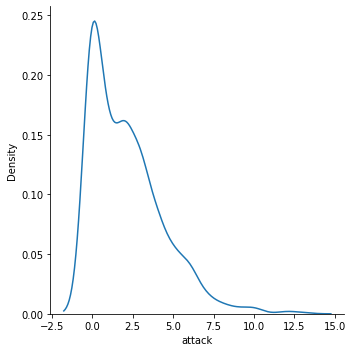

In [387]:
sns.displot(data=df, x="attack", kind="kde")

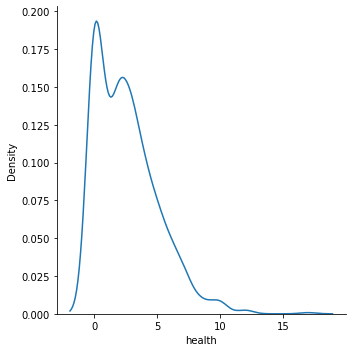

In [388]:
sns.displot(data=df, x="health", kind="kde")

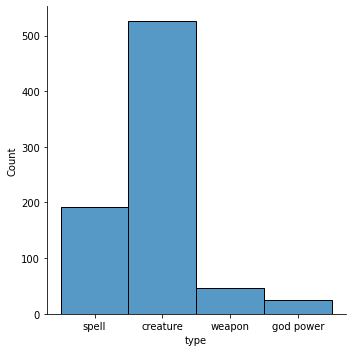

In [389]:
sns.displot(data=df, x="type")

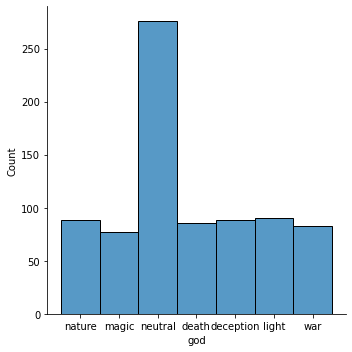

In [390]:
sns.displot(data=df, x="god")

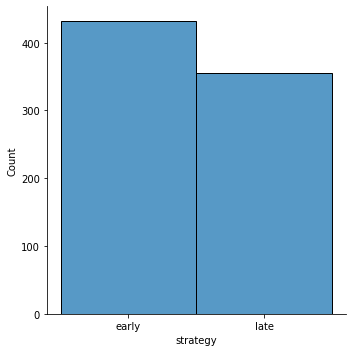

In [391]:
sns.displot(data=df, x="strategy")

## Entendendo a diferença entre as classes e possíveis outliers

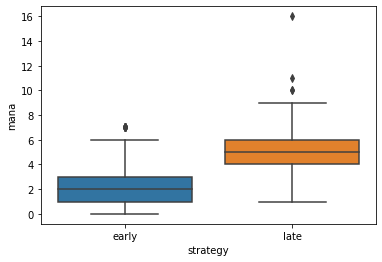

In [392]:
ax = sns.boxplot(x="strategy", y="mana", data=df)

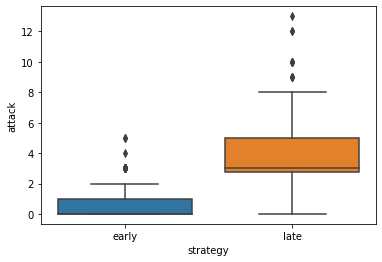

In [393]:
ax = sns.boxplot(x="strategy", y="attack", data=df)

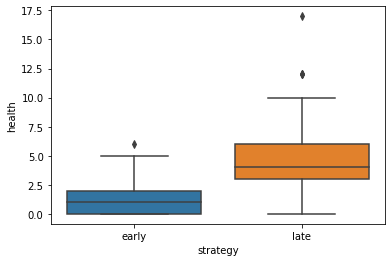

In [394]:
ax = sns.boxplot(x="strategy", y="health", data=df)

<AxesSubplot:xlabel='type', ylabel='count'>

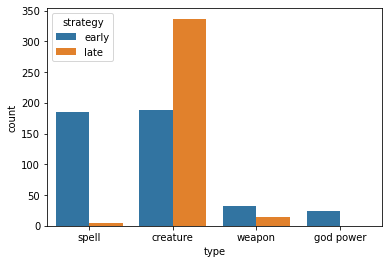

In [395]:
sns.countplot(x="type", hue="strategy", data=df)

<AxesSubplot:xlabel='god', ylabel='count'>

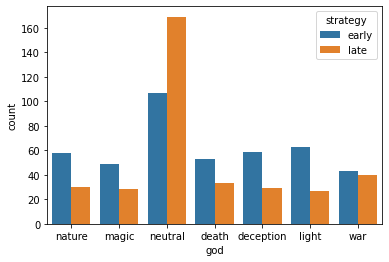

In [396]:
sns.countplot(x="god", hue="strategy", data=df)

### Considerações
 * Olhando as variáveis numéricas, foi possível ver que o early game possui valores menores que o late, além <br> 
   de ambos possuírem alguns outliers. <br><br>
   
 * Nas variáveis categóricas, algumas se destacam, como o valores 'spell' ou 'god power' da feature 'strategy', mas no geral existe uma sutil diferença entre as classes.

## Remoção de outliers utilizando Interquartile range (IQR)

IQR é uma técnica estatistica para remoção de outliers, retirando assim valores abaixo do primeiro quartil (Q1–1.5 * IQR)<br>
e maiores que o terceiro (Q3+1.5 * IQR)<br>

![TItle](images/IQR.png)


In [397]:
def remove_outlier_IQR(category, column):
    df_iqr = df.query("strategy == @category")
    
    Q1 = df_iqr[column].quantile(0.25)
    Q3 = df_iqr[column].quantile(0.75)
    IQR = Q3-Q1
    
    idx = df_iqr[(df_iqr[column] < (Q1 - 1.5 * IQR)) | 
              (df_iqr[column] > (Q3 + 1.5 * IQR))
             ].index
    
    df.drop(idx, inplace=True)

In [398]:
remove_outlier_IQR("early", "mana")
remove_outlier_IQR("late", "mana")

remove_outlier_IQR("early", "attack")
remove_outlier_IQR("late", "attack")

remove_outlier_IQR("early", "health")
remove_outlier_IQR("late", "health")

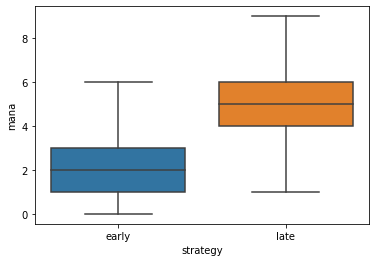

In [399]:
ax = sns.boxplot(x="strategy", y="mana", data=df)

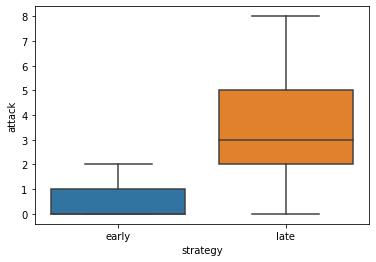

In [400]:
ax = sns.boxplot(x="strategy", y="attack", data=df)

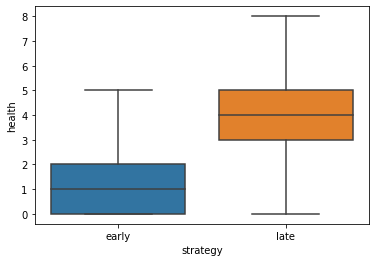

In [401]:
ax = sns.boxplot(x="strategy", y="health", data=df)

## Correlações

In [402]:
# Transforma variaveis string em categórica
df[['strategy','god','type']] = df[['strategy','god','type']].astype("category")

df['cat_strategy'] = df['strategy'].cat.codes
df['cat_god'] = df['god'].cat.codes
df['cat_type'] = df['type'].cat.codes

In [403]:
df.head()

,id,name,mana,attack,health,type,god,strategy,cat_strategy,cat_god,cat_type
0,1118,Firewine,5,0,0,spell,nature,early,0,4,2
2,244,Aetherfuel Alchemist,6,4,4,creature,neutral,late,1,5,0
3,215,Millenium Matryoshka,4,2,2,creature,neutral,late,1,5,0
4,87013,Poison Peddler,4,1,3,creature,neutral,late,1,5,0
5,230,Canopic Hoarder,5,2,1,creature,death,late,1,0,0


In [404]:
feature_columns = ['cat_strategy', 'cat_god', 'cat_type', 'mana', 'attack', 'health']
df[feature_columns].corrwith(df['cat_strategy']).sort_values(ascending=False)

cat_strategy    1.000000
attack          0.739174
health          0.723954
mana            0.655101
cat_god         0.176740
cat_type       -0.490034
dtype: float64

<AxesSubplot:>

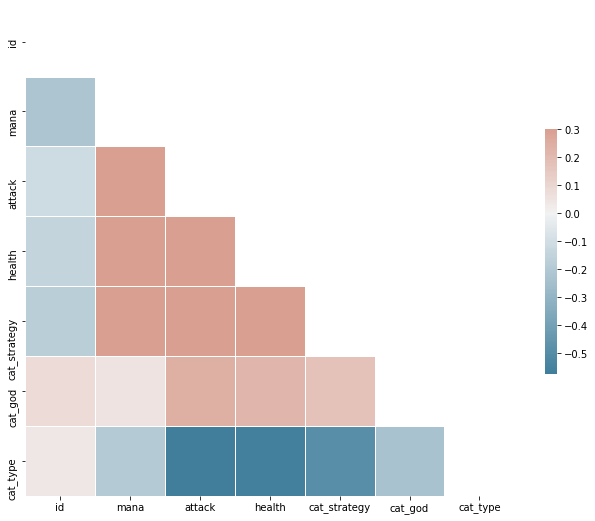

In [405]:
# Matriz de correlação
corr = df.corr()

# Cria gráfico
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [406]:
with open('../data/data_prep.pkl', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)